In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-ivp-rk)=
# Runge–Kutta methods

```{index} ! Runge–Kutta method
```

We come now to one of the major and most-used types of methods for initial-value problems: **Runge–Kutta** (RK) methods.[^RK] They are one-step methods in the sense of {eq}`onestepODE`, though they are not often written in that form. RK methods boost the accuracy past first order by evaluating the ODE function $f(t,u)$ more than once per time step.

[^RK]: Americans tend to pronounce these German names as "run-ghuh kut-tah."

## A second-order method

Consider a series expansion of the exact solution to $u'=f(t,u)$,

```{math}
:label: taylor2
\hat{u}(t_{i+1}) = \hat{u}(t_i) + h \hat{u}'(t_i) + \frac{1}{2}h^2 \hat{u}''(t_i) + O(h^3) .
```

If we replace $\hat{u}'$ by $f$ and keep only the first two terms on the right-hand side, we would obtain the Euler method. To get more accuracy we will need to compute or estimate the third term as well. Note that

```{math}
\hat{u}'' = f' = \frac{d f}{d t} = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial u} \frac{d u}{d t} = f_t + f_u f,
```

where we have applied the multidimensional chain rule to the derivative, because both of the arguments of $f$ depend on $t$. Using this expression in {eq}`taylor2`, we obtain

```{math}
  :label: rkexactexpand
  \hat{u}(t_{i+1}) = \hat{u}(t_i) + h\left[f\bigl(t_i,\hat{u}(t_i)\bigr) +
    \frac{h}{2}f_t\bigl(t_i,\hat{u}(t_i)\bigr) +
    \frac{h}{2}f\bigl(t_i,\hat{u}(t_i)\bigr)\,f_u\bigl(t_i,\hat{u}(t_i)\bigr)\right] \\
  + O(h^3).
```

We have no desire to calculate and then code those partial derivatives of $f$ directly; an approximate approximation is called for. Observe that

```{math}
  :label: mvtaylor2
  f\bigl(t_i+\alpha,\hat{u}(t_i)+\beta\bigr) = f\bigl(t_i,\hat{u}(t_i)\bigr) +
  \alpha f_t\bigl(t_i,\hat{u}(t_i)\bigr) + \beta f_u\bigl(t_i,\hat{u}(t_i)\bigr) +
  O\bigl(\alpha^2 + |\alpha\beta| + \beta^2\bigr).
```

Matching this expression to the term in brackets in {eq}`rkexactexpand`, it seems natural to select $\alpha = h/2$ and $\beta = \frac{1}{2}h f\bigl(t_i,\hat{u}(t_i)\bigr)$. Doing so, we find

```{math}
  \hat{u}(t_{i+1}) = \hat{u}(t_i) + h\left[f\bigl(t_i+\alpha,\hat{u}(t_i)+\beta\bigr)\right] +
  O(h\alpha^2 + h|\alpha \beta| + h\beta^2 + h^3).
```

Truncation of the series here results in a new one-step method.

::::{proof:definition} Improved Euler method (IE2)
The improved Euler method is the one-step formula
```{math}
:label: IE
{u}_{i+1} = u_i +  hf\left(t_i+\tfrac{1}{2}h,u_i+\tfrac{1}{2}h f(t_i,u_i)\right).
```
::::

Thanks to the definitions above of $\alpha$ and $\beta$, the omitted terms are of size

```{math}
  O(h\alpha^2 + h|\alpha \beta| + h\beta^2 + h^3) = O(h^3).
```

Therefore $h\tau_{i+1}=O(h^3)$, and the order of accuracy of improved Euler is two.

## Implementation

Runge–Kutta methods are called *multistage* methods. We can see why if we interpret {eq}`IE` from the inside out. In the first stage, the method takes an Euler half-step to time $t_i+\frac{1}{2}h$:

```{math}
\begin{split}
  k_1 &= h f(t_i,u_i), \\
  v &= u_i + \tfrac{1}{2}k_1.
\end{split}
```

The second stage employs an Euler-style strategy over the whole time step, but using the value from the first stage to get the slope:

```{math}
\begin{split}
  k_2 &= h f\left(t_i+\tfrac{1}{2}h,v\right),\\
  {u}_{i+1} &= u_i + k_2.
\end{split}
```

Our implementation of IE2 is shown in {numref}`Function {number} <function-ie2>`.

(function-ie2)=

````{proof:function} ie2
**Improved Euler method for an IVP**

```{code-block} julia1
:lineno-start: 1
"""
    ie2(ivp,n)

Apply the Improved Euler method to solve the given IVP using `n`
time steps. Returns a vector of times and a vector of solution
values.
"""
function ie2(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0),n+1)

    # Time stepping.
    for i in 1:n
        uhalf = u[i] + h/2*ivp.f(u[i],ivp.p,t[i]);
        u[i+1] = u[i] + h*ivp.f(uhalf,ivp.p,t[i]+h/2);
    end
    return t,u
end
```
````

## More Runge–Kutta methods

While it is interesting to interpret IE2 as a pair of Euler-like steps, the Taylor series derivation is the only way to see that it will be more accurate than Euler, and it is also the path to deriving other methods. Moving to higher orders of accuracy requires introducing additional stages, each having free parameters so that more terms in the series may be matched. The amount of algebra grows rapidly in size and complexity, though there is a sophisticated theory for keeping track of it. We do not give the derivation details.

A generic $s$-stage RK method takes the form

```{math}
  :label: rk
  \begin{split}
    k_1 &= h f(t_i,u_i),\\
    k_2 &= h f(t_i+c_1h,u_i + a_{11}k_1),\\
    k_3 &= h f(t_i+c_2h, u_i + a_{21}k_1 + a_{22}k_2),\\
    &\vdots\\
    k_s &= h f(t_i + c_{s-1}h, u_i + a_{s-1,1}k_1 + \cdots +
    a_{s-1,s-1}k_{s-1}),\\
    \mathbf{u}_{i+1} &= u_i + b_1k_1 + \cdots + b_s k_s.
  \end{split}
```

This recipe is completely determined by the number of stages $s$ and the constants $a_{ij}$, $b_j$, and $c_i$.  Often an RK method is presented as just a table of these numbers, as in

```{math}
  \begin{array}{r|ccccc}
    0 &  &  & & & \\
    c_1 & a_{11} & & &\\
    c_2 & a_{21} & a_{22} & & &\\
    \vdots & \vdots & & \ddots & &\\
    c_{s-1} & a_{s-1,1} & \cdots & & a_{s-1,s-1}&\\[1mm] \hline
    \rule{0pt}{2.25ex}    & b_1 & b_2 & \cdots & b_{s-1} & b_s
  \end{array}
```

For example, IE2 is given by

```{math}
  \begin{array}{r|cc}
    \rule{0pt}{2.75ex}0 &  &  \\
    \rule{0pt}{2.75ex}\frac{1}{2} & \frac{1}{2} &\\[1mm] \hline
    \rule{0pt}{2.75ex}& 0 & 1
  \end{array}
```

Here are two more two-stage, second-order methods, **modified Euler** and **Heun's method**, respectively:

```{math}
  \begin{array}{r|cc}
    \rule{0pt}{2.75ex}0 &  &  \\
    \rule{0pt}{2.75ex}1 & 1 &\\[1mm] \hline
    \rule{0pt}{2.75ex}& \frac{1}{2} & \frac{1}{2}
  \end{array}
  \qquad \qquad
  \begin{array}{r|cc}
   \rule{0pt}{2.75ex} 0 &  &  \\
   \rule{0pt}{2.75ex} \frac{2}{3} & \frac{2}{3} &\\[1mm] \hline
   \rule{0pt}{2.75ex} & \frac{1}{4} & \frac{3}{4}
  \end{array}
```

::::{attention}
Euler, improved Euler (IE2), and modified Euler (ME2) are all distinct numerical methods.
::::

The most commonly used RK method, and perhaps the most popular IVP method of all, is the fourth-order one given by

```{math}
  :label: rk4
  \begin{array}{r|cccc}
    \rule{0pt}{2.75ex}0 &  & & & \\
    \rule{0pt}{2.75ex}\frac{1}{2} & \frac{1}{2} & & &\\
    \rule{0pt}{2.75ex}\frac{1}{2} & 0 & \frac{1}{2} & &\\
    \rule{0pt}{2.75ex}1 & 0 & 0 & 1\\[1mm] \hline
    \rule{0pt}{2.75ex}& \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
  \end{array}
```

This formula is often referred to as *the* fourth-order RK method, even though there are many others, and we refer to it as **RK4**.  Written out, the recipe is as follows.

::::{proof:definition} Fourth-order Runge–Kutta method (RK4)

```{math}
  :label: rk4def
  \begin{split}
    k_1 &= hf(t_i,u_i), \\
    k_2 &= hf(t_i+h/2,u_i+k_1/2),\\
    k_3 &= hf(t_i+h/2,u_i+k_2/2),\\
    k_4 &= hf(t_i+h,u_i+k_3),\\
    u_{i+1} &= u_i + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4.
  \end{split}
```
::::

Our implementation is given in {numref}`Function {number} <function-rk4>`.

(function-rk4)=

````{proof:function} rk4
**Fourth-order Runge-Kutta for an IVP**

```{code-block} julia1
:lineno-start: 1
"""
    rk4(ivp,n)

Apply the common Runge-Kutta 4th order method to solve the given 
IVP using `n` time steps. Returns a vector of times and a vector of
solution values.
"""
function rk4(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0),n+1)

    # Time stepping.
    for i in 1:n
        k₁ = h*ivp.f( u[i],      ivp.p, t[i]     )
        k₂ = h*ivp.f( u[i]+k₁/2, ivp.p, t[i]+h/2 )
        k₃ = h*ivp.f( u[i]+k₂/2, ivp.p, t[i]+h/2 )
        k₄ = h*ivp.f( u[i]+k₃,   ivp.p, t[i]+h   )
        u[i+1] = u[i] + (k₁ + 2(k₂+k₃) + k₄)/6
    end
    return t,u
end
```
````


(demo-rk-converge)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the IVP $u'=\sin[(u+t)^2]$ over $0\le t \le 4$, with $u(0)=-1$.

In [2]:
f = (u,p,t) -> sin((t+u)^2)
tspan = (0.0,4.0)
u₀ = -1.0

ivp = ODEProblem(f,u₀,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: -1.0

We use a `DifferentialEquations` solver to construct an accurate approximation to the exact solution.

In [3]:
u_ref = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14);

Now we perform a convergence study of our two Runge–Kutta implementations.

In [4]:
n = [ round(Int,2*10^k) for k in 0:0.5:3 ]
err_IE2,err_RK4 = [],[]
for n in n
    t,u = FNC.ie2(ivp,n)
    push!( err_IE2, maximum( @.abs(u_ref(t)-u) ) )
    t,u = FNC.rk4(ivp,n)
    push!( err_RK4, maximum( @.abs(u_ref(t)-u) ) )
end

pretty_table([n err_IE2 err_RK4],["n","IE2 error","RK4 error"])

┌──────┬─────────────┬─────────────┐
│    n │   IE2 error │   RK4 error │
├──────┼─────────────┼─────────────┤
│    2 │     1.76903 │    0.820651 │
│    6 │    0.512684 │    0.791925 │
│   20 │   0.0240594 │  0.00081269 │
│   63 │  0.00225327 │  8.06216e-6 │
│  200 │ 0.000222419 │  7.60655e-8 │
│  632 │  2.22528e-5 │   7.513e-10 │
│ 2000 │  2.22177e-6 │ 7.45259e-12 │
└──────┴─────────────┴─────────────┘


The amount of computational work at each time step is assumed to be proportional to the number of stages. Let's compare on an apples-to-apples basis by using the number of $f$-evaluations on the horizontal axis.

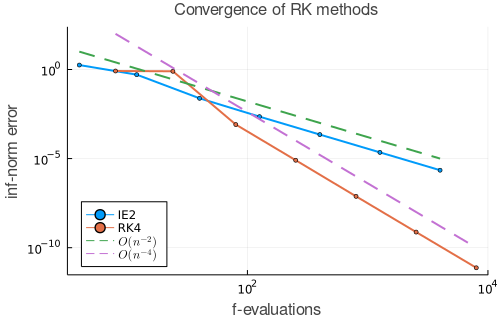

In [5]:
plot([2n 4n],[err_IE2 err_RK4],m=3,label=["IE2" "RK4"],
    xaxis=(:log10,"f-evaluations"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of RK methods",leg=:bottomleft)

plot!(2n,1e-5*(n/n[end]).^(-2),l=:dash,label=L"O(n^{-2})")
plot!(4n,1e-10*(n/n[end]).^(-4),l=:dash,label=L"O(n^{-4})")

The fourth-order variant is more efficient in this problem over a wide range of accuracy.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Efficiency

As with rootfinding and integration, the usual point of view is that evaluations of $f$ are the only significant computations and are therefore to be minimized in number. One of the most important characteristics of a multistage method is that each stage requires an evaluation of $f$; that is, a single time step of an $s$-stage method requires $s$ evaluations of $f$.

The error decreases geometrically as $s$ is incremented, so trading a stage for an increase in order is a good deal. But $s=5$, $6$, or $7$ gives a maximal order of accuracy of $s-1$; this decreases to $s-2$ for $s=8$ and $s=9$, etc. Fourth order is considered adequate and the sweet spot for many applications.

## Exercises

% must stay as #1
(problem-rkhandexamples)=

1. ✍ For each IVP, write out (possibly using a calculator) the first time step of the improved Euler method with $h=0.2$.

    **(a)** $u' = -2t u, \ 0 \le t \le 2, \ u(0) = 2;\  \hat{u}(t) = 2e^{-t^2}$

    **(b)** $u' = u + t, \ 0 \le t \le 1, \ u(0) = 2;\  \hat{u}(t) = -1-t+3e^t$

    **(c)** $(1+x^3)uu' = x^2,\ 0 \le x \le 3, \ u(0) = 1;\ \hat{u}(x) = [1+(2/3)\ln (1+x^3)]^{1/2}$

2. ✍ Use the modified Euler method to solve the problems in the preceding exercise.

3. ⌨ Modify {numref}`Function {number} <function-rk4>` to implement the modified Euler method. Test your function on the IVP in part (a) of Exercise 1 by solving with $n=30,60,90,\ldots,300$ and plotting the convergence of the error at the final time together with a line showing $O(n^{-2})$. 

4. ✍ Use Heun's method to solve the problems in [Exercise 1 above](problem-rkhandexamples).

5. ⌨ Modify {numref}`Function {number} <function-rk4>` to implement Heun's method. Test your function on the IVP in part (a) of Exercise 1 by solving with $n=30,60,90,\ldots,300$ and plotting the convergence of the error at the final time together with a line showing $O(n^{-2})$. 

6. ✍ Use RK4 to solve the problems in [Exercise 1 above](problem-rkhandexamples).

7. ✍ Using {eq}`rkexactexpand` and {eq}`mvtaylor2`, show that the modified Euler method has order of accuracy at least 2.

8. ✍ Using {eq}`rkexactexpand` and {eq}`mvtaylor2`, show that Heun's method has order of accuracy at least 2.

    (problem-rk4converge)=
9. ⌨ For each IVP, compute the solution using {numref}`Function {number} <function-rk4>`. (i) Plot the solution for $n=300$. (ii) For $n=100,200,300,\ldots,1000$, compute the error at the final time and make a log-log convergence plot, including a reference line for fourth-order convergence.

    **(a)** $u''+ 9u = 9t, \: 0< t< 2\pi, \: u(0) = 1,\: u'(0) = 1; \: \hat{u}(t) = t+\cos (3t)$

    **(b)** $u''+ 9u = \sin(2t), \: 0< t< 2\pi, \: u(0) = 2,\: u'(0) = 1$;

    $\quad \hat{u}(t) = (1/5) \sin(3t) + 2 \cos (3t)+  (1/5) \sin (2t)$

    **(c)** $u''- 9u = 9t, \: 0< t< 1, \: u(0) = 2,\: u'(0) = -1; \: \hat{u}(t) = e^{3t} + e^{-3t}-t$

    **(d)** $u''+ 4u'+ 4u = t, \: 0< t< 4, \: u(0) = 1,\: u'(0) = 3/4; \: \hat{u}(t) = (3t+5/4)e^{-2t} + (t-1)/4$

    **(e)** $x^2 y'' +5xy' + 4y = 0,\: 1<x<e^2, \: y(1) = 1, \: y'(1) = -1, \: \hat{y}(x) = x^{-2}( 1 + \ln x)$

    **(f)** $2 x^2 y'' +3xy' - y = 0,\: 1<x<16, \: y(1) = 4, \: y'(1) = -1, \: \hat{y}(x) = 2(x^{1/2} + x^{-1})$

    **(g)** $x^2 y'' -xy' + 2y = 0,\: 1<x<e^{\pi}, \: y(1) = 3, \: y'(1) = 4$;

    $\quad \hat{y}(x) = x \left[ 3 \cos \left( \ln x \right)+\sin \left( \ln x \right) \right]$

    **(h)** $x^2 y'' + 3xy' + 4y = 0,\: e^{\pi/12} < x < e^{\pi}, \: y(e^{\pi/12}) = 0,  \: y'(e^{\pi/12}) = -6$;

    $\quad \hat{y}(x) = x^{-1} \left[ 3 \cos \left( 3 \ln x \right)+\sin \left( 3 \ln x \right) \right]$

10. ⌨ Do [Exercise 6.3.4](problem-SIR), but using {numref}`Function {number} <function-rk4>` instead of `solve`.

11. ✍ Consider the problem $u'=c u$, $u(0) = 1$ for constant $c$ and $t>0$.

    **(a)** Find an explicit formula in terms of $h$ and $c$ for $u_{i+1}/u_i$ in the modified Euler method.

    **(b)** Show that if $ch=-3$, then $|u_i|\to\infty$ as $i\to\infty$ while the exact solution $\hat{u}(t)$ approaches zero as $t\to\infty$.